# Ex 1: Manipulating Spectra Part 1 - `Spectrum`

# Notebook Initialization

In [23]:
%load_ext autoreload
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
%matplotlib inline

In [29]:
%autoreload


import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np
from scipy.integrate import quad

import darkhistory.physics as physics
import darkhistory.spec.spectools as spectools
from darkhistory.spec.spectrum import Spectrum

## DarkHistory Binning

DarkHistory deals extensively with spectra, so it is important to understand how we generally deal with the problem of discretizing spectra in our code. 

Here are some general rules followed in DarkHistory when dealing with spectra: 

1. Spectra in DarkHistory should be viewed as a series of bins indexed by energies $E_i$, each containing some number of particles at that energy. 


2. Each bin has some *bin width*, and two *bin boundaries*. We always use log-binning for all of the bins, with the bin boundaries taken to be the midpoint in log-space between two bin energies. The first and last bins are assumed to have their energies at the center of the bin in log-space. 


3. Consider a spectrum $dN/dE$ that is a function of the energy $E$. There are several ways in which we discretize this spectrum over some chosen energy abscissa $E_i$ (a vector of energy values over which we want to approximate the function):

    a. The first is to simply assign the value of $dN/dE$ to each bin:
    
    $$ \frac{dN}{dE} (E_i) \approx \mathbf{S}[E_i] $$ 
    
    where $\mathbf{S}$ is some vector of entries. This method is fast, but may fail to capture sharp features if the binning is insufficiently fine. 

    b. The second method is implemented numerically in [`spectools.discretize`](https://hongwanliu.github.io/DarkHistory/html/_autosummary/darkhistory/spec/spectools/darkhistory.spec.spectools.discretize.html). Given an abscissa $E_i$, total number and energy conservation is enforced, and a good approximation to the spectrum is returned. See the linked documentation for more details.

## Introduction

Individual spectra are stored as [`Spectrum`](https://hongwanliu.github.io/DarkHistory/html/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) objects in DarkHistory. 

The manipulation of spectral data in this code is done through several specialized classes, all of them equipped with internal methods that make data manipulation easy. Functions useful for creating and manipulating these classes are provided in `spec.spectools`. 

## `Spectrum` Class - Introduction

The most basic class that we use is the `Spectrum` class. This contains an abscissa, the spectrum values at each abscissa, as well as the redshift. 

To create our first `Spectrum`, we will use the function `spec.spectools.discretize`. This takes a function which returns the $dN/dE$ of a continuous spectrum, and produces a discretized version of it, stored in a `Spectrum` class. 

Our first example will be a `Spectrum` containing a CMB spectrum. `physics.CMB_spec` returns $dN/dE$ at a particular energy and temperature of the blackbody spectrum. This function can be passed to `spec.spectools.discretize` to create a `Spectrum` object.

In [55]:
T = 1.5 # The temperature in eV of the CMB.

def CMB_dNdE_at_T(eng):
    return physics.CMB_spec(eng, T)

eng = 10**((np.arange(120)-90)*(1/10))
discrete_CMB = spectools.discretize(eng, CMB_dNdE_at_T)

`discrete_CMB` is a `Spectrum` object. This object has several attributes, but the three most important ones are the energy abscissa `self.eng`, the $dN/dE$ value at each point `self.dNdE`, as well as the redshift (always $1+z$ in this project) `self.rs`.

`self.eng` should be viewed as the center of a bin. The bin boundary between two successive abscissa values $E_1$ and $E_2$ is $\frac{1}{2} ( \log E_1 + \log E_2)$. The first and last abscissa values are taken to lie at the center of their respective bins.  

We can now plot the spectrum contained in `discrete_CMB` as a check. 

[1e-08, 10000.0, 1e-10, 1e+20]

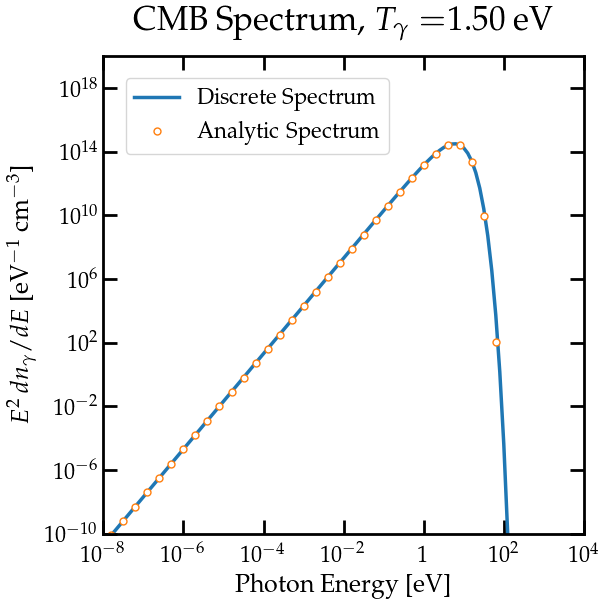

In [56]:
plt.figure()

plt.loglog()

discrete_spec, = plt.plot(
    discrete_CMB.eng, discrete_CMB.eng**2*discrete_CMB.dNdE, label='Discrete Spectrum'
)
analytic_spec, = plt.plot(
    eng, eng**2*physics.CMB_spec(eng, T), 'o', marker='o', markersize='5', 
    markevery=3, markerfacecolor='w', label='Analytic Spectrum'
)

plt.legend(handles=[discrete_spec, analytic_spec])

plt.title(r'CMB Spectrum, $T_\gamma = $'+'{:3.2f}'.format(T)+' eV')
plt.xlabel('Photon Energy [eV]')
plt.ylabel('$E^2 \, dn_\gamma/dE$ [eV$^{-1}$ cm$^{-3}$]')
plt.axis([1e-8, 1e4, 1e-10, 1e20])

We should also set the `rs` attribute to the correct redshift. Here, we use `physics.TCMB`, which takes in a redshift as an argument, to calculate what the redshift $1+z$ is at the temperature `T` that we selected earlier. 

In [6]:
rs = T/physics.TCMB(1)

discrete_CMB.rs = rs

## `Spectrum` Class - Addition and Multiplication

You can add two `Spectrum` objects together, or add a scalar to a `Spectrum`. Similarly, you can multiply two `Spectrum` objects, or multiply by a scalar. These operations can be performed as if `Spectrum` were an array. 

## `Spectrum` Class - Number and Energy

Let's initialize a new `Spectrum` that is essentially a copy of `discrete_CMB`. 

In [7]:
test_CMB = Spectrum(discrete_CMB.eng, discrete_CMB.dNdE, discrete_CMB.rs)

To find the total number of particles stored in this spectrum, we can use the method `self.totN()`, with no arguments. Particle number in a bin is always given by 

$$ N = \frac{dN}{dE} \times E \, d\log E$$

where $d \log E$ is the log bin width of the bin (this can be computed with `spec.spectools.get_log_bin_width`).

This agrees with the actual numerical quadrature over the CMB spectrum given by `physics.CMB_spec` from `eng[0]` to `eng[-1]`, since `spec.spectools.discretize` ensures that the total number of particles *and* total energy in each bin are exactly the value that would be obtained by quadrature of the CMB spectrum. 

In [8]:
print('Number of particles stored in test_CMB: ', test_CMB.totN())
print('Number of particles by quadrature: ', quad(CMB_dNdE_at_T, eng[0], eng[-1])[0])

Number of particles stored in test_CMB:  106996520624887.56
Number of particles by quadrature:  106996520624887.56


`self.totN` can also be used to find the total number of particles in various bins. This is done by specify the bin boundaries: the code below returns the total number of particles in the first two bins. The bin boundaries do not need to be integers. 

In [9]:
print('# of particles in first and second bin: ',
      test_CMB.totN(bound_type='bin', bound_arr=np.array([0,1,2]))
     )

# of particles in first and second bin:  [2.78182594e-06 7.41174243e-06]


One can also use `Spectrum.N` to get a list of number of particles in each bin. This is related to the `Spectrum` type, which we will come back to later.

In [10]:
print('# of particles in first and second bin: ', test_CMB.N[0:2])

# of particles in first and second bin:  [2.78182594e-06 7.41174243e-06]


`self.totN` can also return the total number of particles between different energy boundaries: 

In [11]:
print('# of particles between 0.2 and 0.45 eV, 0.45 eV and 0.6 eV: ', 
      test_CMB.totN(bound_type='eng', bound_arr=np.array([0.2, 0.45, 0.6]))
     )

# of particles between 0.2 and 0.45 eV, 0.45 eV and 0.6 eV:  [1.45086071e+12 1.37229631e+12]


The function `self.toteng()` serves a similar purpose. Energy in a bin is always evaluated as
$$ E = \frac{dN}{dE} \times \, E^2 d \log E $$

In [12]:
def CMB_EdNdE_at_T(eng):
    return eng*physics.CMB_spec(eng, T)

print('Total energy stored in test_CMB: ', test_CMB.toteng())
print('Total energy by quadrature: ', quad(CMB_EdNdE_at_T, eng[0], eng[-1])[0])

Total energy stored in test_CMB:  433524976666076.9
Total energy by quadrature:  433524976666076.75


## `Spectrum` Class - Redshifting and Underflow

Photon redshifting is built in to the `Spectrum` class.

In [60]:
test_CMB.redshift(rs/2)

The resulting redshifted spectrum conserves total number, with the total energy reduced by half. Here is a plot of the new spectrum, and a comparison of the total number and total density.

Original total number of particles:  106996520624887.56
Redshifted total number of particles:  106996520624887.56
Ratio:  1.0
**********************************************************
Original total energy:  433524976666076.9
Redshifted total energy:  216762488333038.28
Ratio:  2.0000000000000013


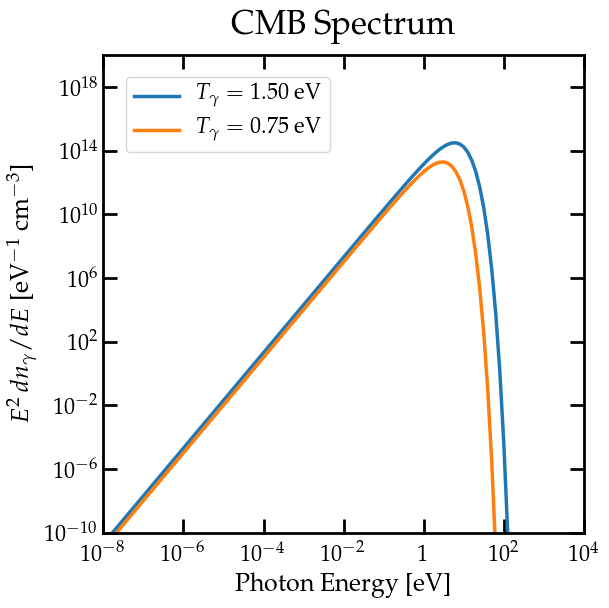

In [66]:
plt.figure()

plt.loglog()

orig_spec, = plt.plot(discrete_CMB.eng, discrete_CMB.eng**2*discrete_CMB.dNdE, label=r'$T_\gamma =$ '+'{:3.2f}'.format(T)+' eV')
# Divide by 8, because we are plotting densities here.
redshifted_spec, = plt.plot(test_CMB.eng, test_CMB.eng**2*test_CMB.dNdE/8, label=r'$T_\gamma =$ '+'{:3.2f}'.format(T/2)+' eV')

plt.legend(handles=[orig_spec, redshifted_spec])

plt.title('CMB Spectrum')
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$E^2 \, dn_\gamma/dE$ [eV$^{-1}$ cm$^{-3}$]')
plt.axis([1e-8, 1e4, 1e-10, 1e20])

print('Original total number of particles: ', discrete_CMB.totN())
print('Redshifted total number of particles: ', test_CMB.totN())
print('Ratio: ', discrete_CMB.totN()/test_CMB.totN())
print('**********************************************************')
print('Original total energy: ', discrete_CMB.toteng())
print('Redshifted total energy: ', test_CMB.toteng())
print('Ratio: ', discrete_CMB.toteng()/test_CMB.toteng())


Note that the energy abscissa doesn't change after redshifting. Number and energy are both conserved by assigning particles that redshift below the energy abscissa into an underflow. Underflow number and energy are included in `self.totN()` and `self.toteng()`. 

In [15]:
print('Number of particles in underflow: ',test_CMB.underflow['N'])
print('Energy in underflow: ', test_CMB.underflow['eng'])

Number of particles in underflow:  2.215481661602498e-05
Energy in underflow:  1.5535382351407223e-14


## `Spectrum` - Rebinning and Shifting

The energy abscissa of a `Spectrum` object can be adjusted. 

If every photon in a bin, with energies $E_1, \cdots, E_n$, loses some amount of energy, and now has new energies $E_1', \cdots, E_n'$, the abscissa can be shifted down to the new abscissa, while conserving number, using the function `self.shift_eng`. 

A closely related function is `self.rebin`. This re-distributes the spectrum into a new abscissa, while conserving number *and* energy. The new abscissa must have a maximum energy higher than the old abscissa, so that there is no overflow. 

As an example, we will perform redshifting explicitly using these two functions from $1+z$ to $(1+z)/2$. Photons at an energy $E_n$ are shifted to energy $E_n/2$ using `self.shift_eng`. Then, we rebin the resulting spectrum back into the original abscissa to get the redshifted spectrum using `self.rebin`. The result is identical to calling the `self.redshift` function.

Original total number of particles:  106996520624887.56
Redshifted total number of particles:  106996520624887.56
Ratio:  1.0
**********************************************************
Original total energy:  433524976666076.9
Redshifted total energy:  216762488333038.25
Ratio:  2.0000000000000018


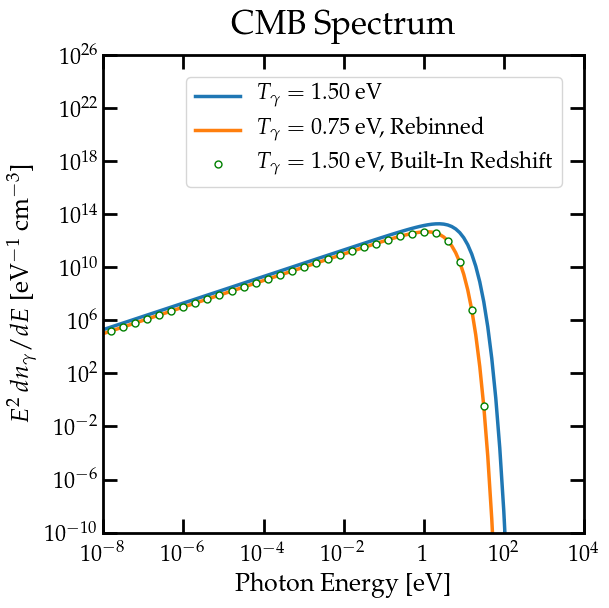

In [72]:
test_CMB_2 = Spectrum(discrete_CMB.eng, discrete_CMB.dNdE, discrete_CMB.rs)
test_CMB_2.shift_eng(discrete_CMB.eng/2)
test_CMB_2.rebin(discrete_CMB.eng)

plt.figure()

plt.loglog()

orig_spec, = plt.plot(discrete_CMB.eng, 
                      discrete_CMB.dNdE, 
                      label=r'$T_\gamma =$ '+'{:3.2f}'.format(T)+' eV')
rebinned_spec, = plt.plot(test_CMB_2.eng, 
                          test_CMB_2.dNdE/2**3, 
                          label=r'$T_\gamma =$ '+'{:3.2f}'.format(T/2)+' eV, Rebinned')
redshifted_spec, = plt.plot(test_CMB.eng, 
                            test_CMB.dNdE/2**3,'go',
                            marker='o', markersize='5', 
                            markevery=3, markerfacecolor='w', 
                            label=r'$T_\gamma =$ '+'{:3.2f}'.format(T)+' eV, Built-In Redshift')


plt.legend(handles=[orig_spec, rebinned_spec, redshifted_spec])

plt.title('CMB Spectrum')
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$E^2 \, dn_\gamma/dE$ [eV$^{-1}$ cm$^{-3}$]')
plt.axis([1e-8, 1e4, 1e-10, 1e26])

print('Original total number of particles: ', discrete_CMB.totN())
print('Redshifted total number of particles: ', test_CMB_2.totN())
print('Ratio: ', discrete_CMB.totN()/test_CMB_2.totN())
print('**********************************************************')
print('Original total energy: ', discrete_CMB.toteng())
print('Redshifted total energy: ', test_CMB_2.toteng())
print('Ratio: ', discrete_CMB.toteng()/test_CMB_2.toteng())


## `Spectrum` Types: N vs. dN/dE

So far, all of the `Spectrum` objects store $dN/dE$ as the raw data in the array. However, we can also store an array of $N$ as the raw data instead. This can be advantageous if speed is an issue, and the more convenient form to store is as an array of $N$'s instead of $dN/dE$'s. 

To create a `Spectrum` storing $N$'s instead, include the keyword argument `spec_type = 'N'` (`spec_type = 'dNdE'` is the default). 

Alternatively, one can also create a $dN/dE$ `Spectrum` object, and then use the function `Spectrum.switch_spec_type`. 

In [17]:
test_CMB_N = Spectrum(discrete_CMB.eng, discrete_CMB.dNdE, discrete_CMB.rs)
print('The Spectrum type is: ', test_CMB_N.get_spec_type())
print('The dN/dE of particles in the first 5 entries is: ')
print(test_CMB_N.dNdE[0:5])
print('The number of particles in the first 5 entries is: ')
print(test_CMB_N.N[0:5])
test_CMB_N.switch_spec_type()
print('The Spectrum type is now: ', test_CMB_N.get_spec_type())
print('The dN/dE of particles in the first 5 entries is: ')
print(test_CMB_N.dNdE[0:5])
print('The number of particles in the first 5 entries is: ')
print(test_CMB_N.N[0:5])

AttributeError: 'Spectrum' object has no attribute 'get_spec_type'

Let's just check that everything works okay with this new spectrum type, repeating all of the steps before using $N$ instead:

In [ ]:
test_CMB_N.redshift(rs/2)
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

orig_spec, = plt.plot(discrete_CMB.eng, discrete_CMB.N, label='Original Spectrum')
redshifted_spec, = plt.plot(test_CMB_N.eng, test_CMB.N/2**3, label='Redshifted Spectrum')

plt.legend(handles=[orig_spec, redshifted_spec], fontsize=24)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('CMB Spectrum', fontsize=28)
plt.xlabel('Photon Energy [eV]',fontsize=24)
plt.ylabel('dN/dV in each bin [cm$^{-3}$]',fontsize=24)
plt.axis([1e-8, 1e4, 1e-10, 1e20])

print('Original total number of particles: ', discrete_CMB.totN())
print('Redshifted total number of particles: ', test_CMB.totN())
print('Ratio: ', discrete_CMB.totN()/test_CMB.totN())
print('**********************************************************')
print('Original total energy: ', discrete_CMB.toteng())
print('Redshifted total energy: ', test_CMB.toteng())
print('Ratio: ', discrete_CMB.toteng()/test_CMB.toteng())